In [1]:
from train_dreambooth_peft import load_combine_checkpoint

/raid/sourab/transformers/src/transformers/utils/hub.py:122: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-01-16 14:00:55.582038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 14:00:55.582087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 14:00:55.582952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 14:00:55.588780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance

In [2]:
from diffusers import StableDiffusionXLPipeline, AutoencoderKL
import torch
vae = AutoencoderKL.from_pretrained(
        "madebyollin/sdxl-vae-fp16-fix",
    )
pipe = StableDiffusionXLPipeline.from_pretrained(
                    "stabilityai/stable-diffusion-xl-base-1.0",
                    vae=vae,
                    torch_dtype=torch.float16,
                )



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
pipe.to("cuda")

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
#pipe = load_combine_checkpoint("watercolour_lora", pipeline)
def initialize_new_tokens(inserting_toks, text_encoders, tokenizers):
    if inserting_toks is None:
        return
    for tokenizer, text_encoder in zip(tokenizers, text_encoders):
        assert isinstance(
            inserting_toks, list
        ), "inserting_toks should be a list of strings."
        assert all(
            isinstance(tok, str) for tok in inserting_toks
        ), "All elements in inserting_toks should be strings."

        special_tokens_dict = {"additional_special_tokens": inserting_toks}
        tokenizer.add_special_tokens(special_tokens_dict)
        text_encoder.resize_token_embeddings(len(tokenizer))

inserting_toks = ["<s0>", "<s1>"]
text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]
initialize_new_tokens(inserting_toks, text_encoders, tokenizers)


In [5]:
pipe = load_combine_checkpoint("teapot_lora_dreambooth", pipe, "teapot") # download it from https://huggingface.co/smangrul/teapot_lora_dreambooth
pipe = load_combine_checkpoint("watercolour_style_lora_dreambooth", pipe, "watercolour") # download it from https://huggingface.co/smangrul/watercolour_style_lora_dreambooth


/raid/sourab/peft-dreambooth-ui/train_dreambooth_peft.py:202: UserWarning: text_encoder is not in {'has_config': 'true', 'library': 'peft', 'unet': '{\n  "alpha_pattern": {},\n  "auto_mapping": null,\n  "base_model_name_or_path": null,\n  "bias": "none",\n  "fan_in_fan_out": false,\n  "inference_mode": false,\n  "init_lora_weights": true,\n  "layers_pattern": null,\n  "layers_to_transform": null,\n  "loftq_config": {},\n  "lora_alpha": 64,\n  "lora_dropout": 0.0,\n  "megatron_config": null,\n  "megatron_core": "megatron.core",\n  "modules_to_save": null,\n  "peft_type": "LORA",\n  "r": 64,\n  "rank_pattern": {},\n  "revision": null,\n  "target_modules": [\n    "to_out.0",\n    "to_k",\n    "to_q",\n    "to_v"\n  ],\n  "task_type": null\n}'}
  warnings.warn(f"{model_name} is not in {metadata}")
/raid/sourab/peft-dreambooth-ui/train_dreambooth_peft.py:202: UserWarning: text_encoder_2 is not in {'has_config': 'true', 'library': 'peft', 'unet': '{\n  "alpha_pattern": {},\n  "auto_mapping":

In [141]:
def create_ties_weighted_adapter(pipe, adapter_name, adapters, weights):
    pipe.unet.add_weighted_adapter(adapters,
                                    weights,
                                    adapter_name,
                                    combination_type="ties_svd",
                                    density=0.5)
    return pipe
    

In [142]:
%%time
if "ties_watercolour_teapot" in pipe.unet.peft_config:
    pipe.unet.delete_adapter("ties_watercolour_teapot")
pipe = create_ties_weighted_adapter(pipe, "ties_watercolour_teapot", ["teapot","watercolour"], [1.0, 1.0])

CPU times: user 2min 34s, sys: 1.8 s, total: 2min 35s
Wall time: 1min 3s


In [146]:
pipe.unet.set_adapter("ties_watercolour_teapot")

  0%|          | 0/30 [00:00<?, ?it/s]

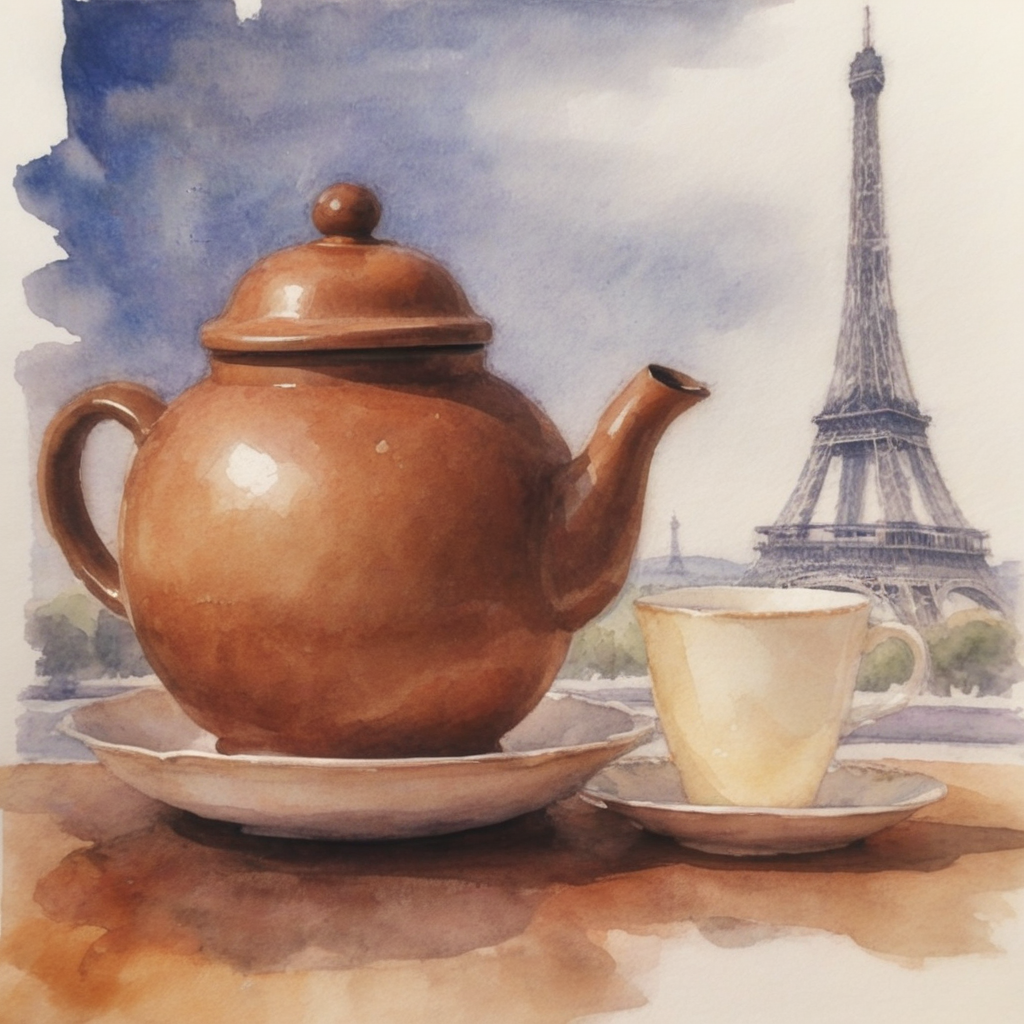

In [163]:
pipe.to("cuda")
validation_prompt = "A brown <s0><s1> teapot with Eiffel tower in the background in watercolour style"
seed = None
generator = (
            torch.Generator(device="cuda").manual_seed(seed)
            if seed
            else None
                )
pipeline_args = {"prompt": validation_prompt}
with torch.cuda.amp.autocast():
    image = pipe(**pipeline_args, generator=generator, num_inference_steps=30).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

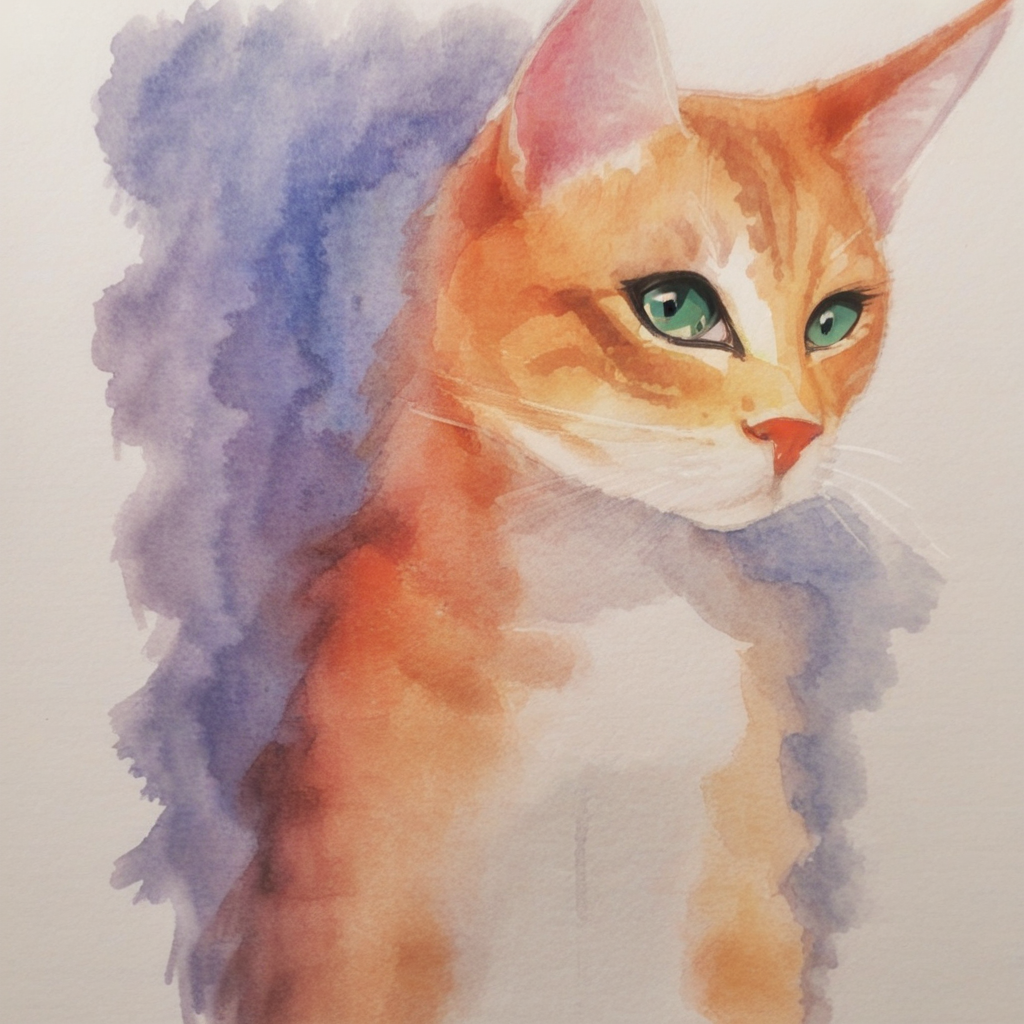

In [161]:
pipe.to("cuda")
validation_prompt = "A cat in watercolour style"
seed = None
generator = (
            torch.Generator(device="cuda").manual_seed(seed)
            if seed
            else None
                )
pipeline_args = {"prompt": validation_prompt}
with torch.cuda.amp.autocast():
    image = pipe(**pipeline_args, generator=generator, num_inference_steps=30).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

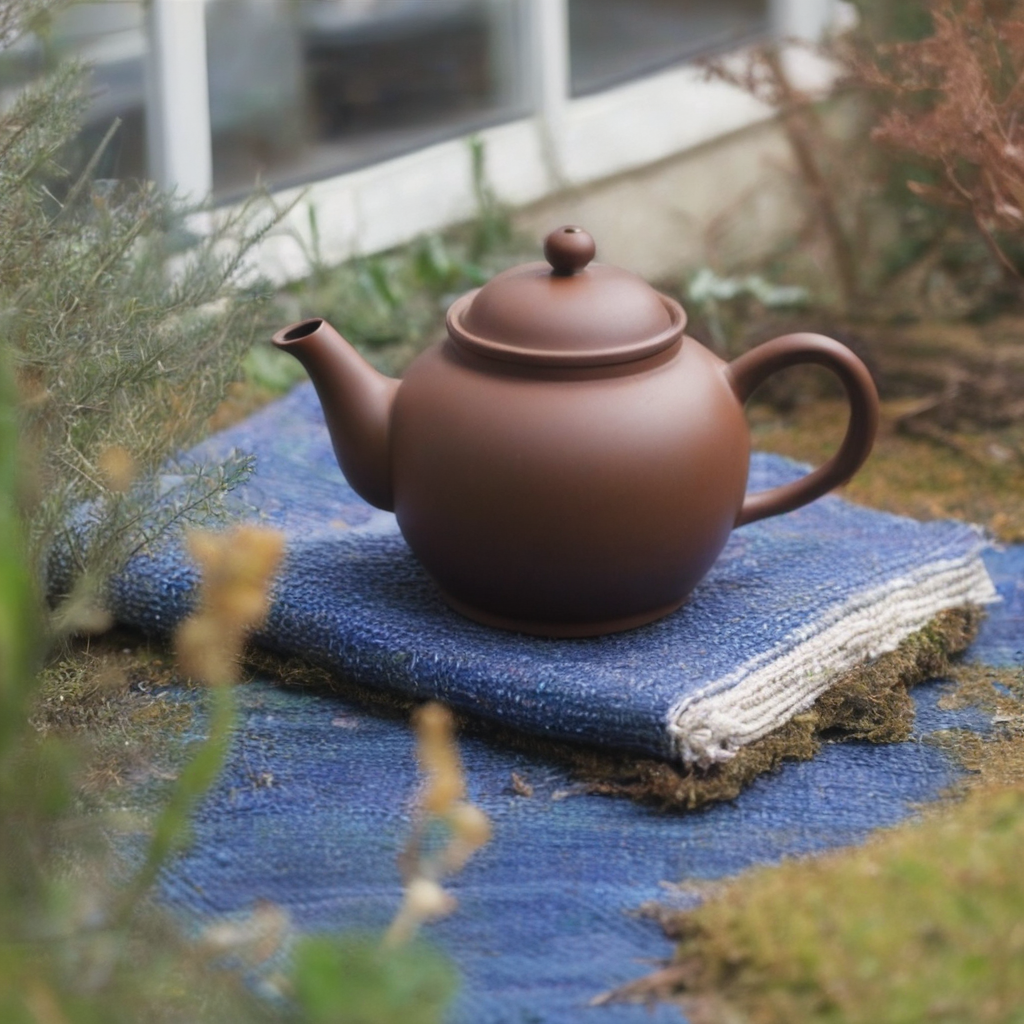

In [157]:
pipe.to("cuda")
validation_prompt = "A side view of brown <s0><s1> teapot on a blue rug in a garden"
seed = None
generator = (
            torch.Generator(device="cuda").manual_seed(seed)
            if seed
            else None
                )
pipeline_args = {"prompt": validation_prompt}
with torch.cuda.amp.autocast():
    image = pipe(**pipeline_args, num_inference_steps=30).images[0]
image